In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as ss
import common_func as cf
import math

In [2]:
def find_trend(y, years):
    X_sm = sm.add_constant(years)
    lr = sm.OLS(y, X_sm).fit()
    return lr


def add_trend(y, years, add):
    if add:
        y_new = y + 0.0002 * years
        return y_new
    else:
        return y
    

In [13]:
def fit_exp(maxP, years, return_period):
    lnmaxP = np.log(maxP)
    y = add_trend(lnmaxP, years, False)
    lr = find_trend(y, years)
    alpha, beta = lr.params
#     print(lr.summary())
    ybar,std, skew = cf.findmoments(y)
    n = len(years)
#     print(beta)
    tbar = np.mean(years)
    zp = ss.norm.ppf(1 - 1/return_period)

    # Vogel 2011 EQ 7
    xp = np.exp(ybar + beta*(years - tbar) + zp * std)
    return xp,beta
    

In [14]:
def vogel_results(beta,del_t, rp,std):
    # EQ 9
    mag_f = np.exp(beta * del_t)
    cdf = 1-1/rp
    z_po = ss.norm.ppf(cdf)

    # EQ 12
    T_f = 1 /(1 - ss.norm.cdf(z_po -  (beta * del_t/ std)))
    return mag_f, T_f

100 year return period precipitation: 6.18 inch


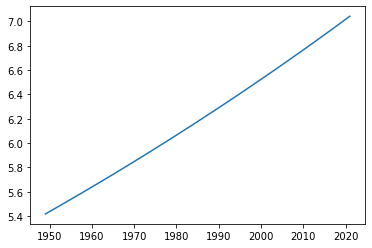

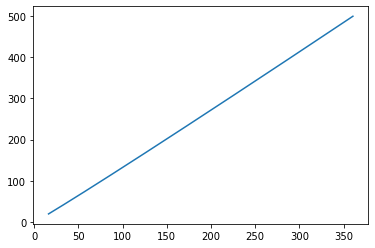

In [15]:
data = pd.read_csv('precip.csv')
maxP, years = cf.annual_max(data)
lnmaxP = np.log(maxP)
ybar,std, skew = cf.findmoments(lnmaxP)
zp = ss.norm.ppf(0.99)
xp = np.exp(ybar + zp * std)
print('100 year return period precipitation:%5.2f' %xp,'inch')

# Plotting 100 year return period precipitation for different years
m, beta = fit_exp(maxP, years, 100)
plt.plot(years,m)
plt.show()
return_periods = np.arange(20,500)

mag_f, T_f = vogel_results(beta,10, return_periods,std)


# Plotting 100 year return period precipitation for different years
plt.plot(T_f, return_periods)
plt.show()

In [16]:
delta_t = np.arange(0,105,5)
return_periods = [100, 200, 500, 1000]

In [17]:
results = pd.DataFrame()
for rp in return_periods: 
    results.loc[:, f"{rp} year storm"] = vogel_results(beta, delta_t, rp,std)[1]
results.columns


Index(['100 year storm', '200 year storm', '500 year storm',
       '1000 year storm'],
      dtype='object')

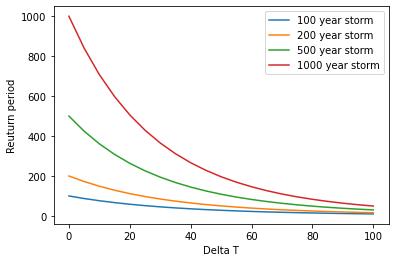

In [18]:
plt.plot(delta_t,results.iloc[:,:], label = results.columns)
plt.xlabel("Delta T")
plt.ylabel("Reuturn period")
plt.legend()

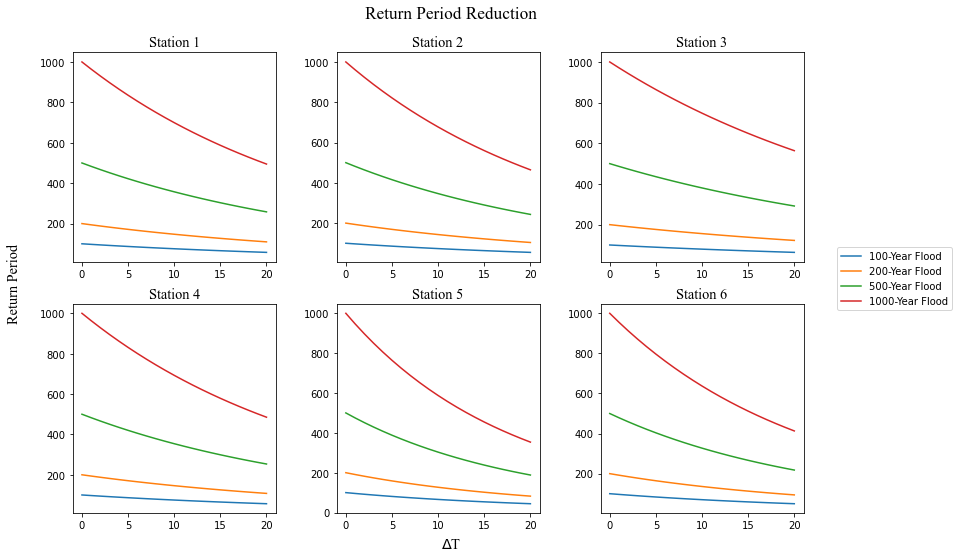

In [23]:
###Subplots
# Stations = ['precip.csv','station_04189000.csv','station_04193500.csv','station_04195500.csv','station_04196800.csv','station_04208000.csv']
Stations = ['station_03117000.csv','station_04189000.csv','station_04193500.csv','station_04195500.csv','station_04196800.csv','station_04208000.csv']

n=math.ceil(len(Stations)/3)
fig, axs = plt.subplots(n,3, figsize=(14,8))#, sharex=True, sharey=True)
hfont = {'fontname':'Times New Roman'}
fig.suptitle('Return Period Reduction', fontsize='xx-large',**hfont)


for s in range(len(Stations)):
    data = pd.read_csv(Stations[s])
    maxP, years = cf.annual_max(data)
    lnmaxP = np.log(maxP)
    ybar,std, skew = cf.findmoments(lnmaxP)
    m, beta = fit_exp(maxP, years, 100)
    delta_t = np.arange(0,21,1)
    return_periods = [100, 200, 500, 1000]
    results = pd.DataFrame()
    for rp in return_periods: 
        results.loc[:, f"{rp}-Year Flood"] = vogel_results(beta, delta_t, rp,std)[1]
    results.columns
    

    ax = axs[math.floor(s/3),s%3]
    ax.plot(delta_t,results.iloc[:,:])
    hfont = {'fontname':'Times New Roman'}
    ax.set_title('Station '+ str(s+1),fontsize='x-large',**hfont)
    
fig.legend(results.columns, loc = 'center right')
fig.text(0.5, 0.04, r'$\Delta$'+'T', ha='center',fontsize='x-large',**hfont)
fig.text(0.06, 0.5, 'Return Period', va='center', rotation='vertical',fontsize='x-large',**hfont)
    
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.85, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.2)
plt.savefig('Tf_delT.png')